# Building CNN model to classify the MNIST-handwritten dataset using PyTorch.

## 1. Downloading and transforming the data.

In [1]:
from torchvision import transforms
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # default values for MNIST dataset
])

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform
)

In [2]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## 2. Looking at the data to get insights.

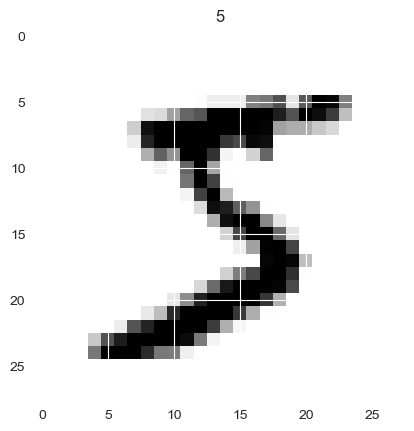

torch.Size([28, 28])


In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray_r')
plt.title(f"{train_data.targets[0]}")
plt.show()
print(train_data.data[0].shape)

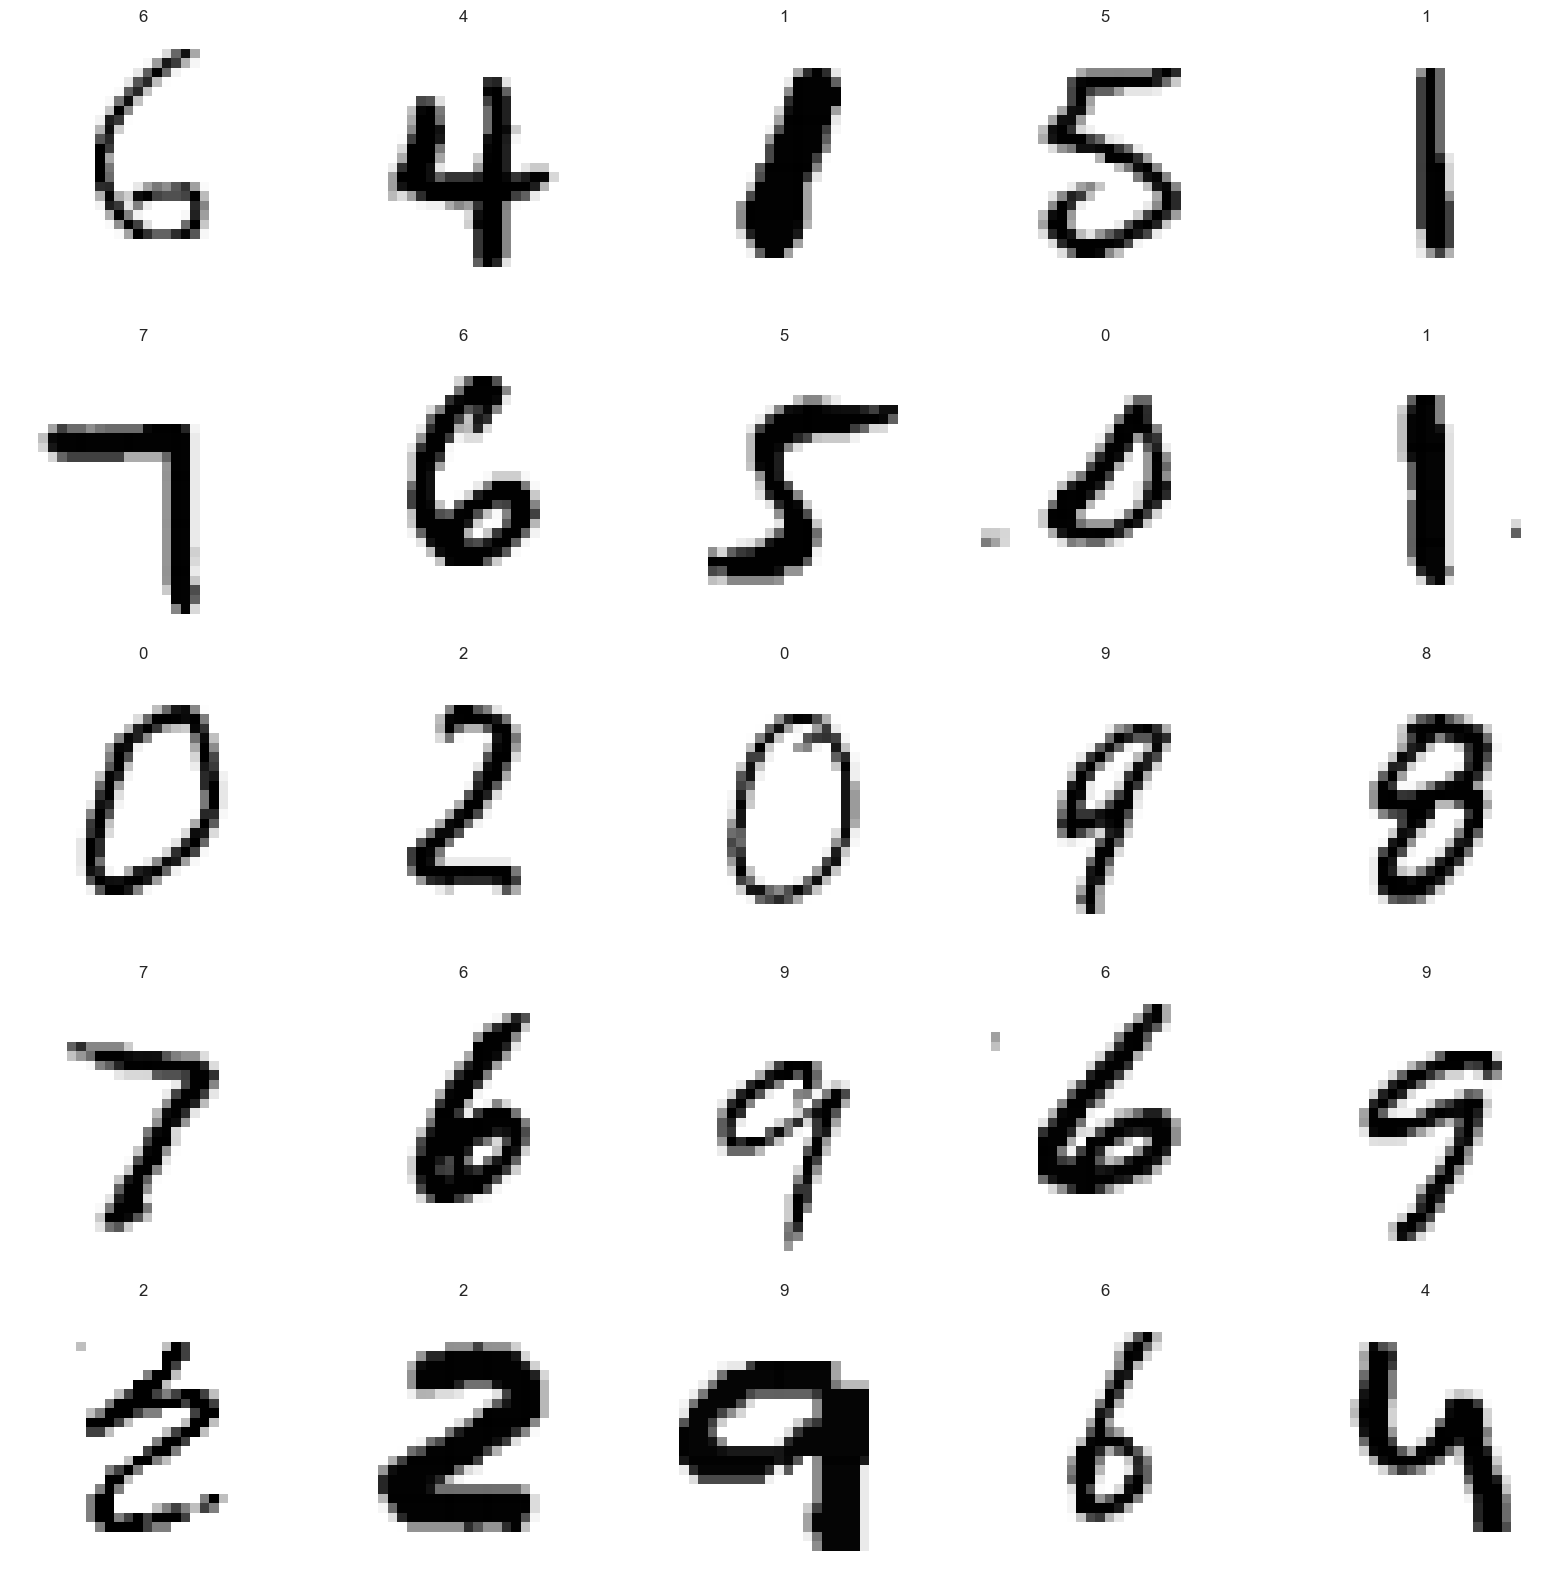

In [4]:
import torch

figure = plt.figure(figsize=(20, 20))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.show()

## 3. Creating DataLoaders.

In [5]:
from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

## 4. Creating a CNN model.

In [20]:
from torch import nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)  # 26 x 26 x 16
        x = F.relu(x)
        x = self.conv2(x)  # 24 x 24 x 32
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 12 x 12 x 128
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # 18432
        x = self.fc1(x)  # 9216
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [21]:
def train(model, device, train_loader, optimizer, epoch, loss_func):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 16 == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({"%.0f" % (100 * batch_idx / len(train_loader))}%)]\tLoss: {"%.6f" % loss.item()}')

In [22]:
def test(model, device, test_loader, loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        f"\nTest set: Average loss: {'%.4f' % test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({'%.0f' % (100 * correct / len(test_loader.dataset))}%)\n")

## 5. Training and evaluating a model.

In [23]:
from torch import optim

learning_rate = 1
gamma = 0.7
n_epochs = 14

device = torch.device('mps')
net = Net().to(device)
loss_func = F.nll_loss
optimizer = optim.Adadelta(net.parameters(), lr=learning_rate)

In [24]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, n_epochs + 1):
    train(net, device, train_loader, optimizer, epoch, loss_func)
    test(net, device, test_loader, loss_func)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303568
Train Epoch: 1 [1024/60000 (2%)]	Loss: 1.349770
Train Epoch: 1 [2048/60000 (3%)]	Loss: 0.414375
Train Epoch: 1 [3072/60000 (5%)]	Loss: 0.745133
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.274639
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.147511
Train Epoch: 1 [6144/60000 (10%)]	Loss: 0.237816
Train Epoch: 1 [7168/60000 (12%)]	Loss: 0.290217
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.120471
Train Epoch: 1 [9216/60000 (15%)]	Loss: 0.379096
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.142479
Train Epoch: 1 [11264/60000 (19%)]	Loss: 0.092436
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.261604
Train Epoch: 1 [13312/60000 (22%)]	Loss: 0.256393
Train Epoch: 1 [14336/60000 (24%)]	Loss: 0.119698
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.096918
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.250442
Train Epoch: 1 [17408/60000 (29%)]	Loss: 0.270054
Train Epoch: 1 [18432/60000 (31%)]	Loss: 0.198253
Train Epoch: 1 [19456/60000 (32%)]	Loss: 0.112931
Train Epoch: 1 [204

### Great! Such model achieves 99% accuracy correctly classifying 9947 of 10000 digits.

## 6. Looking at misclassified digits.

In [61]:
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
net.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    output = net(data)
    pred = output.argmax(dim=1, keepdim=True)
    idxs_mask = ((pred.eq(target.view_as(pred))).view(-1) == False)

    if idxs_mask.numel():
        incorrect_examples.extend(data[idxs_mask].cpu().squeeze().numpy())
        incorrect_labels.extend(target[idxs_mask].cpu().numpy())
        incorrect_pred.extend(pred[idxs_mask].cpu().squeeze().numpy())

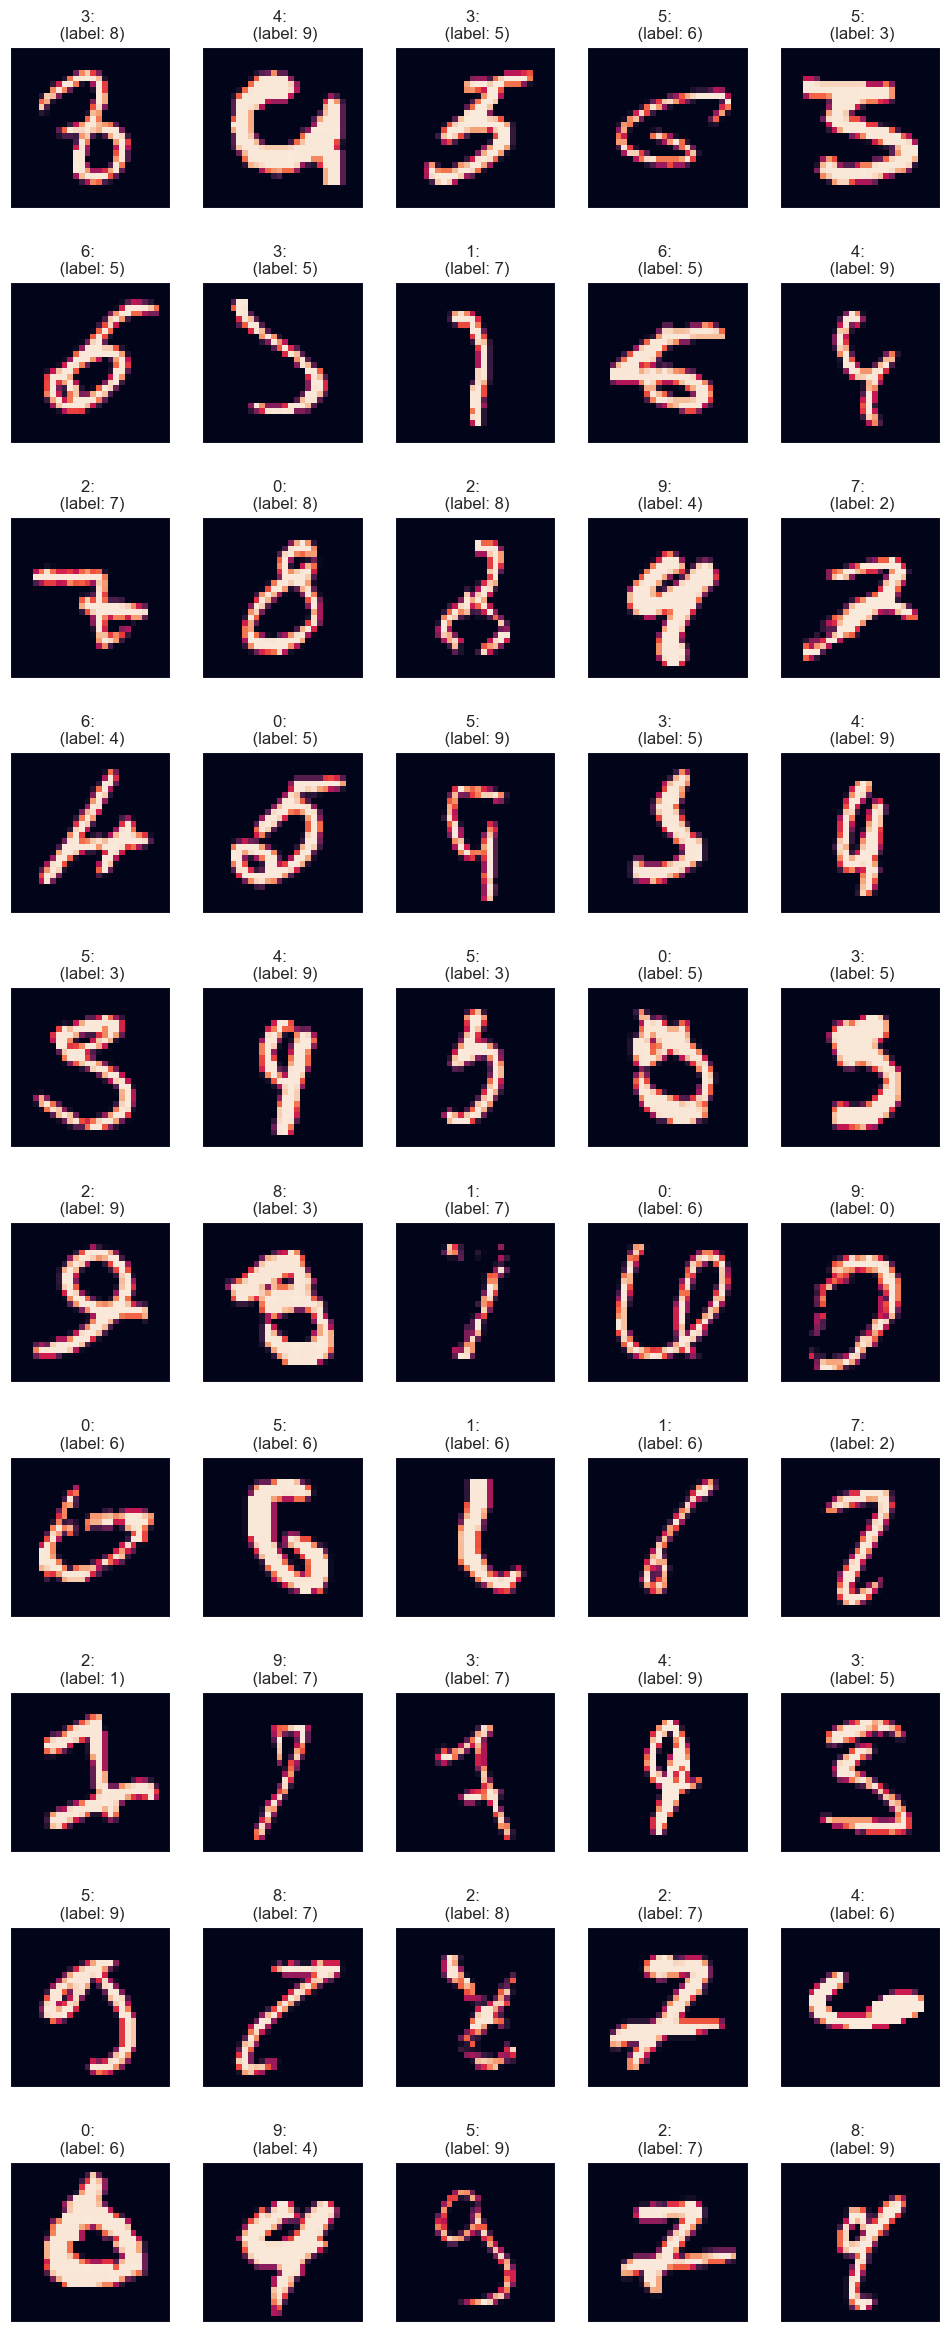

In [70]:
import numpy as np

fig = plt.figure(figsize=(12, 30))

for idx in np.arange(50):
    ax = fig.add_subplot(10, 5, idx + 1, xticks=[], yticks=[])
    img = incorrect_examples[idx]
    plt.imshow(img)
    ax.set_title(f"{incorrect_pred[idx]}: \n (label: {incorrect_labels[idx]})")

Many digits are hardly recognizable even by human, so the model performs really well.

## 7. Conclusion.
This Jupyter Notebook shows how pretty simple CNN model can achieve 99% accuracy in MNIST-handwritten dataset classsification.